# Mevsimsel Olmayan Zaman Serisi Tahminleri için Basit ARIMA Modeli

Bu zorluktaki hedefimiz, zaman serisi analizinin temel kavramlarını tek boyutlu verilere uygulamaktır

Bu zorluklarda şu adımları izleyeceğiz:
1. verileri yükleme ve görselleştirme;
2. modellerimizi eğitme ve tahminler yapma;

##  1. Veri Yükleme
Zorlukta kullanacağımız zaman serisini yükleyerek başlayalım. Veri setini CSV dosyası olarak indirmek için aşağıdaki satırı çalıştırın, ardından CSV'yi bir DataFrame'e yükleyin.

In [1]:
!curl https://d32aokrjazspmn.cloudfront.net/materials/www_usage.csv > data/www_usage.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   377  100   377    0     0    933      0 --:--:-- --:--:-- --:--:--   935


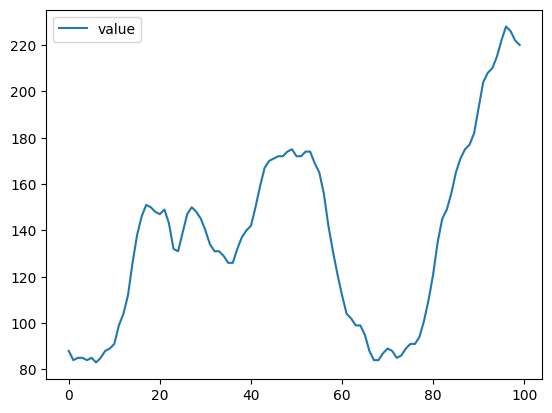

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/www_usage.csv', names=['value'], header=0)
y = df.value

df.plot();

Bu soyut zaman serisi mevsimsel görünmüyor, ancak artan bir trend ve bir şekilde "yapışkan" (yani biraz oto-regresif) özellikler gösteriyor. Bu nedenle Oto-Regresif Hareketli Ortalama (ARIMA) modelleri için iyi bir aday olabilir.

## 2. ARIMA Modeli Oluşturma
ARIMA modelleri (Oto Regresif Entegre Hareketli Ortalama) sayesinde verileri tahmin etmeye çalışacağız.

Bunun için şunları yapmamız gerekecek:
1. zaman serisini nasıl durağanlaştırılacağını bulma (ARIMA'daki I)
2. oto-regresif (AR) kısmını bulma
3. hareketli ortalama (MA) kısmını bulma
4. Uydurma
5. Performansı değerlendirme

### Adım 1 - Durağanlığı Sağlama

ARIMA modelleri yalnızca "durağan" zaman serilerine uygulanır.

👉 [`Genişletilmiş Dickey-Fuller testi`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) kullanarak durağanlığını kesin olarak kontrol edin, özellikle p-değerini

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["value"])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -2.464240
p-value: 0.124419


Durağanlıkta %95 güvenilirlik için p-değeri 0.05'ten küçük olmalıdır.
P-değeri 0.05'ten büyükse, boş hipotezi reddedemeriz (boş hipotez = "süreç durağan değildir").

Zaman serisi durağan değilse, **farklaştırma** yoluyla durağanlaştırılması gerekir.
- Bu, her değer ile bir önceki değer arasındaki farkı almak anlamına gelir (*birinci fark*).
- *İkinci fark* istiyorsanız, farklaştırılmış seri üzerinde işlemi tekrarlayın, vb...

👉 Durağan hale getirmek için ihtiyacımız olan minimum farklaştırma sırasını bulun (görselleştirmek için eğrileri çizin ve emin olmak için adfuller p-değerlerini yazdırın)

<details>
    <summary>İpucu</summary>

`pd.Series.diff`
</details>

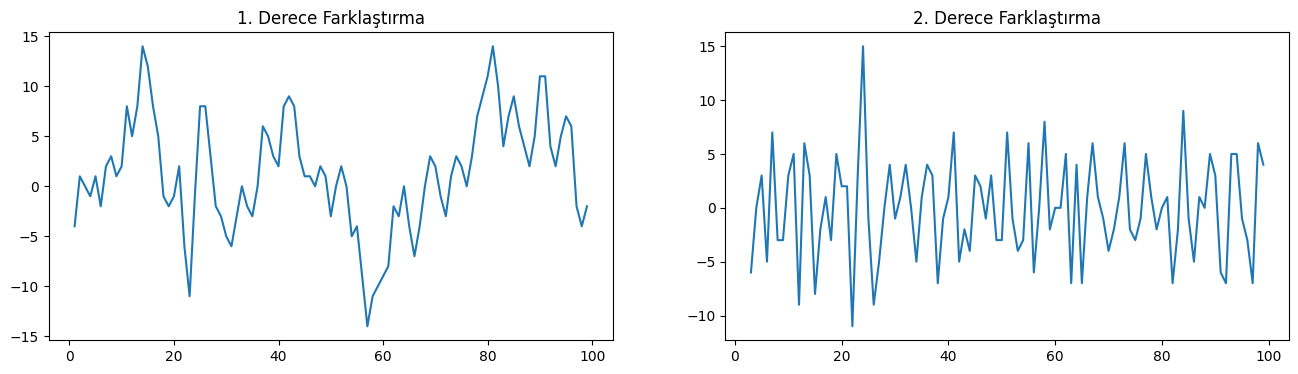

1. Fark p-değeri: 0.070268
2. Fark p-değeri: 0.000000


In [9]:


y_diff1 = y.diff().dropna()

y_diff2 = y_diff1.diff().diff().dropna()



fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].plot(y_diff1); axes[0].set_title('1. Derece Farklaştırma')
axes[1].plot(y_diff2); axes[1].set_title('2. Derece Farklaştırma')
plt.show()

print(f"1. Fark p-değeri: {adfuller(y_diff1)[1]:.6f}")
print(f"2. Fark p-değeri: {adfuller(y_diff2)[1]:.6f}")

Burada bir ve iki fark sırası arasında yakın bir durumumuz var. Zaman serilerini fazla farklaştırmak ARIMA modellerinizin performansını da düşürebilir. Daha yakından bakalım:

👉 1. ve 2. fark sırası için otokorelasyon grafiğini ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) çizin.

(💡Profesyonel ipucu: Her statsmodels grafiği örneklemesinin sonuna `;` ekleyerek veya `plt.show()` çağırarak statsmodels grafiklerinin çoğaltılmasından kaçının)

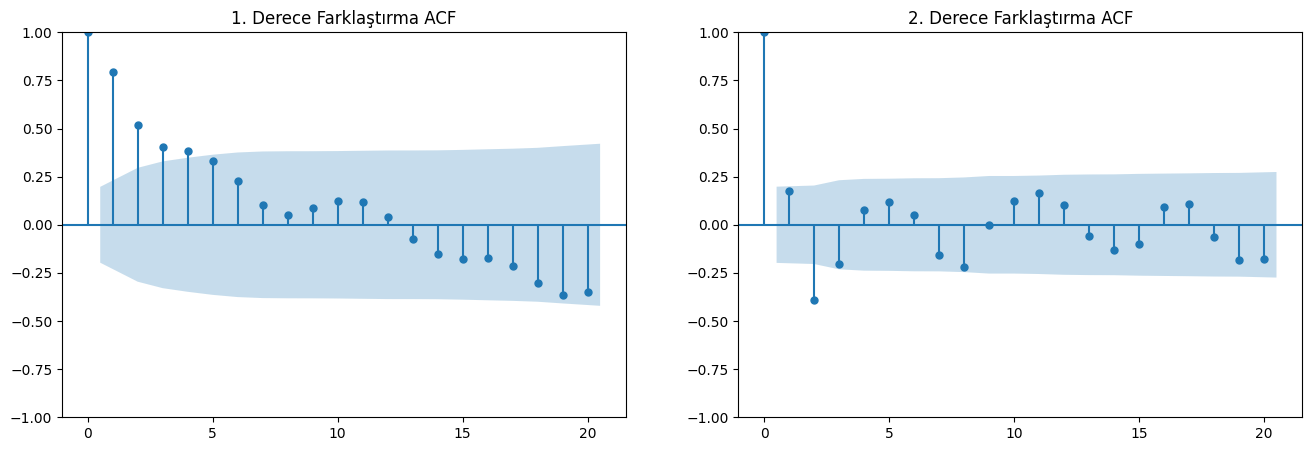

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

fig, axes = plt.subplots(1, 2, figsize=(16, 5))


plot_acf(y.diff().dropna(), ax=axes[0], title="1. Derece Farklaştırma ACF")


plot_acf(y.diff().diff().dropna(), ax=axes[1], title="2. Derece Farklaştırma ACF")

plt.show()

"İkinci sıra fark" otokorelasyon grafiğimizde, 1 numaralı gecikme katsayısı 0'a yakın, ikincisi ise negatif bölgeye kadar uzanıyor. Bu, seriyi aşırı farklaştırdığımızı gösterebilir. (Unutmayın: her zaman 1'e eşit olan 0 numaralı gecikmeyİ hiçbir zaman umursamayız)

👉 (Geçici olarak) yalnızca bir fark sırasını tutalım ve bu seriyi `y_diff` olarak adlandıralım (daha sonra her zaman daha fazla fark deneyebiliriz)

In [11]:
y_diff = y.diff().dropna()

Az önce ARIMA'daki "I" terimini bulduk: durağan olmadan önce 1-fark için `d = 1` ("I", "entegrasyon"u ifade eder, "d" farklaştırma için...)

### Adım 2 - AR sırası (p) ve MA sırasını (q) seçin

#### MA($\color{blue}{q}$) = $Y^{\color{green}{(d)}}$'nin $\color{blue}{ACF}$'inin kesildiği gecikme sayısı

MA sırası (`q`), `y_diff`'e uygulanan otokorelasyon grafiğine ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) bakılarak bulunabilir.

👉 `q`'yu belirleyin

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

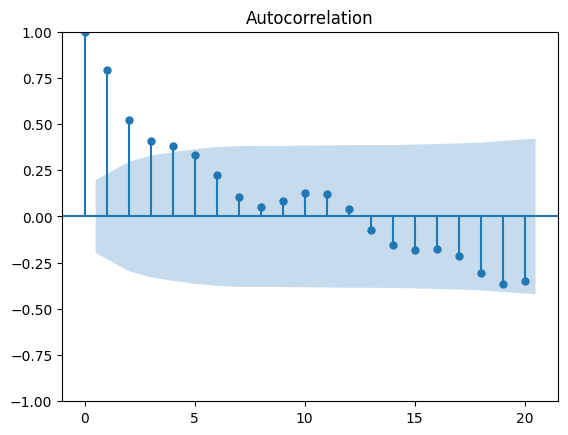

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt


plot_acf(y_diff);
plt.show()

Modelimizi uydurma için değerlendirmemiz gereken maksimum değer q = 4 gibi görünüyor. Ancak, Otomatik-ARIMA kullanacak olsaydık (bu konuda daha sonra ayrıntılı bilgi), q=2 kullanmanın ideal sonuçlar verdiğini görürdük, bu nedenle başlangıçta q=2 ayarlamayı deneyelim.

Şüpheniz olduğunda, Y'yi yeterince açıklayan daha basit modeli seçin.

#### AR($\color{red}{p}$) = $Y^{\color{green}{(d)}}$'nin $\color{red}{PACF}$'inin kesildiği gecikme sayısı

AR sırası (`p`), `y_diff`'e uygulanan **k**ısmi otokorelasyon grafiği [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) incelenerek bulunabilir.

(Kısmi otokorelasyon, ara gecikmelerin katkılarını hariç tuttuktan sonra seri ile gecikmesi arasındaki korelasyon olarak düşünülebilir. Yani, PACF bir şekilde bir gecikme ile seri arasındaki saf korelasyonu iletir)

👉 `p`'yi belirleyin

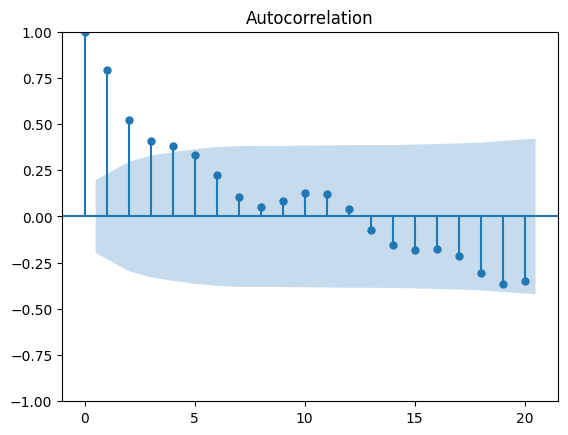

In [18]:
plot_acf(y_diff);

İlk 3 gecikme terimi anlamlılık düzeyinin üstünde göründüğü için `p = 3` seçebiliriz, ancak daha basit bir model `p = 1` ile de gidebiliriz.

### Adım 3 - Modeli oluşturun

Artık ARIMA için `p`, `d` ve `q` değerlerini seçtiğinize göre,

👉 `statsmodels`'den `arima_model`'i oluşturun.
- modeli uydurur
- modeli yazdır (`.summary`)

In [19]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(y, order=(1,1,2))

model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Thu, 22 Jan 2026   AIC                            516.253
Time:                        20:35:24   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.671      -0.373       0.241
sigma2         9.7898      1.421      6.889      0.000       7.005      12.575
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.98   Prob(JB):                         0.95
Heteroskedasticity (H):               0.63   Skew:                            -0.07
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

☝️ P-değerleriniz çok yüksekse, karşılık gelen AR veya SA katsayılarını azaltarak bu terimleri kaldırmayı deneyin.

[`AIC - Akaike Bilgi Kriteri`](https://medium.com/towardsdatascience/the-akaike-information-criterion-c20c8fd832f2) değerini en aza indirerek uyumunuzun genel performansını değerlendirebilirsiniz

(1,1,1) ARIMA modellerinin aşırı uydurmaya karşı daha az şansı olduğu (p-değerleri düşük kalır) ve diğer modellerden neredeyse benzer bir AIC puanı koruduğu görülüyor

## 3. Model performansını değerlendirin

👉 `plot_predict()` yöntemi ile model tahminlerinizi görselleştirin

- Yöntemin varsayılan parametrelerine, özellikle `dynamic` parametrelerine yakından bakın.
- Modelinizin gerçekte böyle iyi bir performansa sahip olacağını düşünüyor musunuz?

In [21]:
from statsmodels.graphics.tsaplots import plot_predict

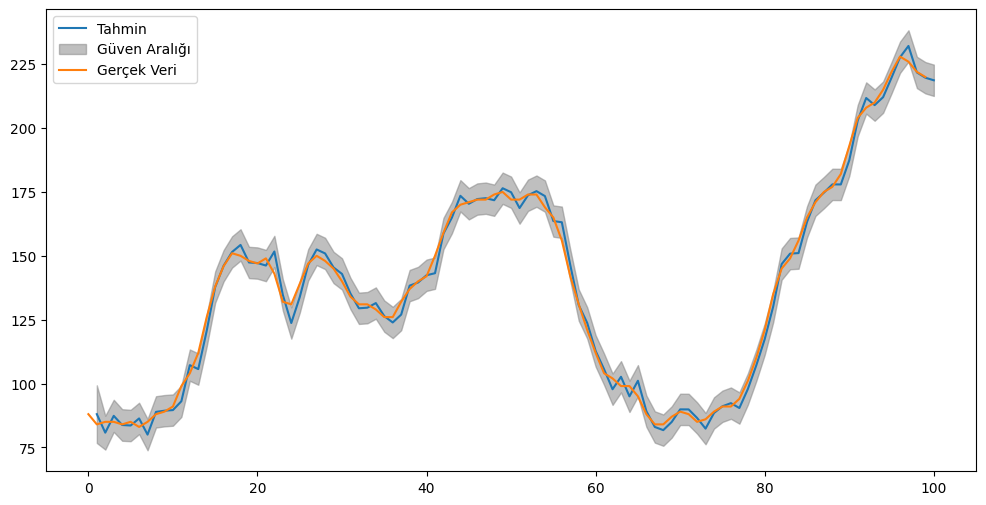

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_predict(model_fit, start=1, end=100, ax=ax)
df.plot(ax=ax) 
plt.legend(['Tahmin', 'Güven Aralığı', 'Gerçek Veri'])
plt.show()

☝️ `dynamic=False`, `y_pred`'i tahmin etmek için mevcut tüm `y` değerlerini kullanır, bu da ARIMA tahminizin $y_t$'yi tahmin etmek için $y_{t-1}$'e kadar kullanmasını sağlar. Gerçekte, özellikle gelecekte birkaç aralığı tahmin etmek istiyorsanız tüm `y`'ye erişiminiz yoktur.

👉 Modelin yalnızca _85'e kadar verilere erişimi_ olan bir durumda _son 15 değeri_ tahmin eden bir tahmini çizmek için `dynamic=True` kullanmayı deneyin. Yani model:
- gerçek [1...85]'e dayalı olarak 86'yı tahmin eder
- sonra 86 için önceden tahmin ettiği değer _artı_ [1...85]'e dayalı olarak 87'yi tahmin eder
- vb...100'e kadar yinelemeli olarak

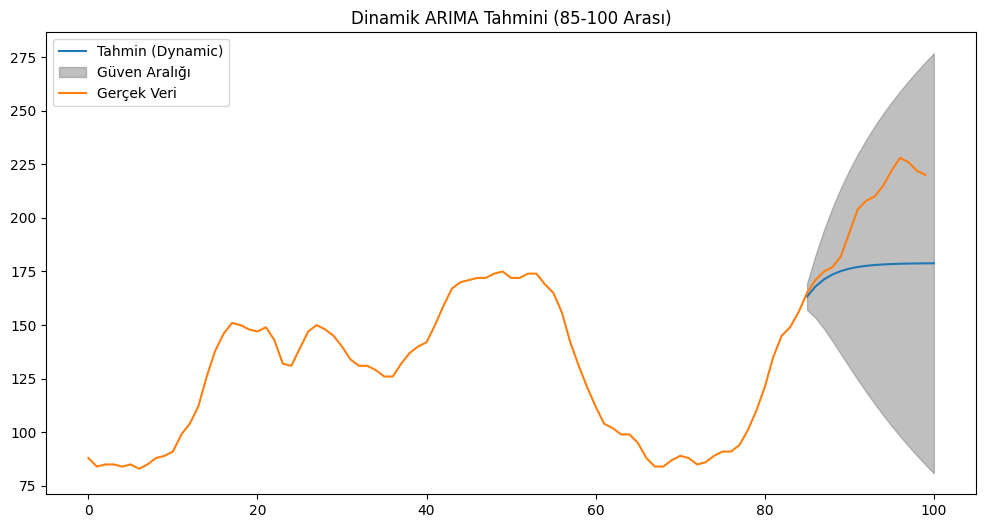

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

plot_predict(model_fit, start=85, end=100, dynamic=True, ax=ax)

df.plot(ax=ax)

plt.title("Dinamik ARIMA Tahmini (85-100 Arası)")
plt.legend(['Tahmin (Dynamic)', 'Güven Aralığı', 'Gerçek Veri'])
plt.show()

☝️ Bu hala _gerçek_ bir tahmin değil! Neden?

<details>
    <summary>Cevap</summary>

Modelimiz uyum aşamasında tüm `y_true` serisini "gördü"!
</details>

### 3.1 Örneklem Dışı Tahminler (gerçek "gelecek")

👉 Test seti için yalnızca son 15 veri noktasını tutarak bir eğitim-test bölümü oluşturun ve ARIMA'nızı yalnızca eğitim setinde eğitin.

In [35]:
from statsmodels.tsa.arima.model import ARIMA

train = y[:85]
test = y[85:]
y_train=test

model = ARIMA(train, order=(1,1,2))

arima_train_fit = model.fit()

arima_train_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   85
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -216.970
Date:                Thu, 22 Jan 2026   AIC                            441.939
Time:                        21:01:35   BIC                            451.662
Sample:                             0   HQIC                           445.848
                                 - 85                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7242      0.137      5.304      0.000       0.457       0.992
ma.L1          0.3901      0.175      2.233      0.026       0.048       0.732
ma.L2         -0.0907      0.161     -0.564      0.573      -0.406       0.224
sigma2        10.0901      1.627      6.201      0.000       6.901      13.279
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.99   Prob(JB):                         0.98
Heteroskedasticity (H):               0.63   Skew:                             0.03
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

👉 Şimdi 85. adımdayız ve geleceği hiç görmedik:
- Sonraki 15 veri noktasını (yani eğitim veri setinizin sonundan sonrasını) "tahmin etmek" için uydurduğunuz `arima` modelinde `get_forecast()` yöntemini kullanın

Yöntem `statsmodels`'den bir `PredictionResultsWrapper` nesnesi döndürür.

**💻 Bu sonucu `forecast_results` adlı bir değişkende saklayın.**

İlk başta gezinmek zordur, ancak işte bazı ipuçları:
- Tahminlerinizi `forecast_results.predicted_mean`'de bulabilirsiniz
- Güven aralıklarınız `forecast_results.conf_int()` tarafından verilir

In [26]:
forecast_results = arima_train_fit.get_forecast(steps=15)

forecast_values = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

👉 Tahmin edilen değerleri ve ayrıca %95 belirsizlik aralığının üst ve alt aralığını çizin

👉 Model performansını geçmişe göre daha iyi kavramak için önceki 85 `y` gerçek veri noktanızı da çizmeyi deneyin

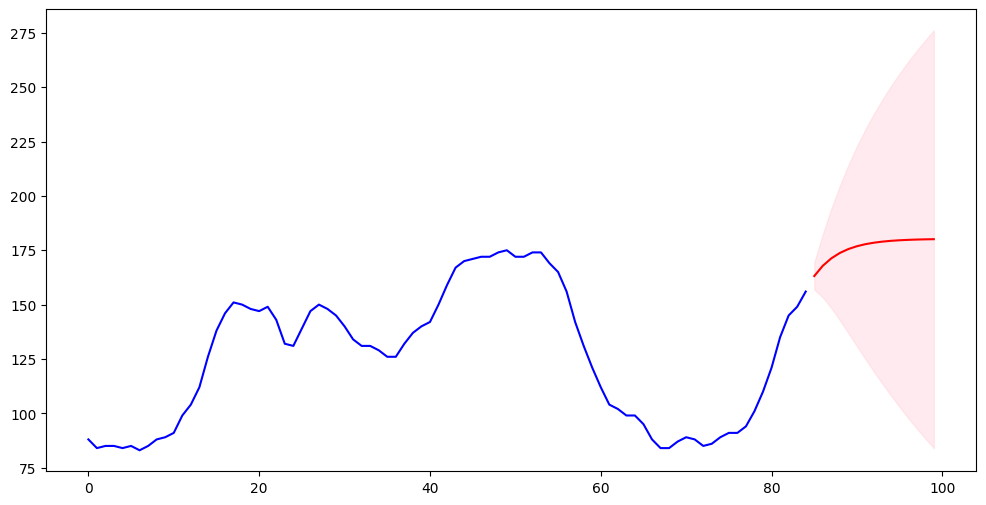

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(train.index, train, label='Geçmiş Gerçek Veri (Train)', color='blue')

plt.plot(forecast_values.index, forecast_values, label='ARIMA Tahmini', color='red')

plt.fill_between(confidence_intervals.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='%95 Güven Aralığı')

### 3.2 %95 güven aralığınıza güvenebilir misiniz? (çıkarım koşulları)

👉 Hiçbir örüntü olmadığından emin olmak için artıkları `model.resid` çizin
- Normal dağılım
- Sıfır ortalama
- Tekdüze varyans
- Oto-regresif örüntü yok (isterseniz artıkları plot_acf yapabilirsiniz)

Not: artıklar `plot_predict(dynamic=False)`'daki gibi tüm verileri 'görerek' oluşturulur

Ayrıca, artıkların yaklaşık olarak normal dağılımda olup olmadığını görmek için artıkların bir histogramını veya KDE uyumunu çizmeyi deneyin.

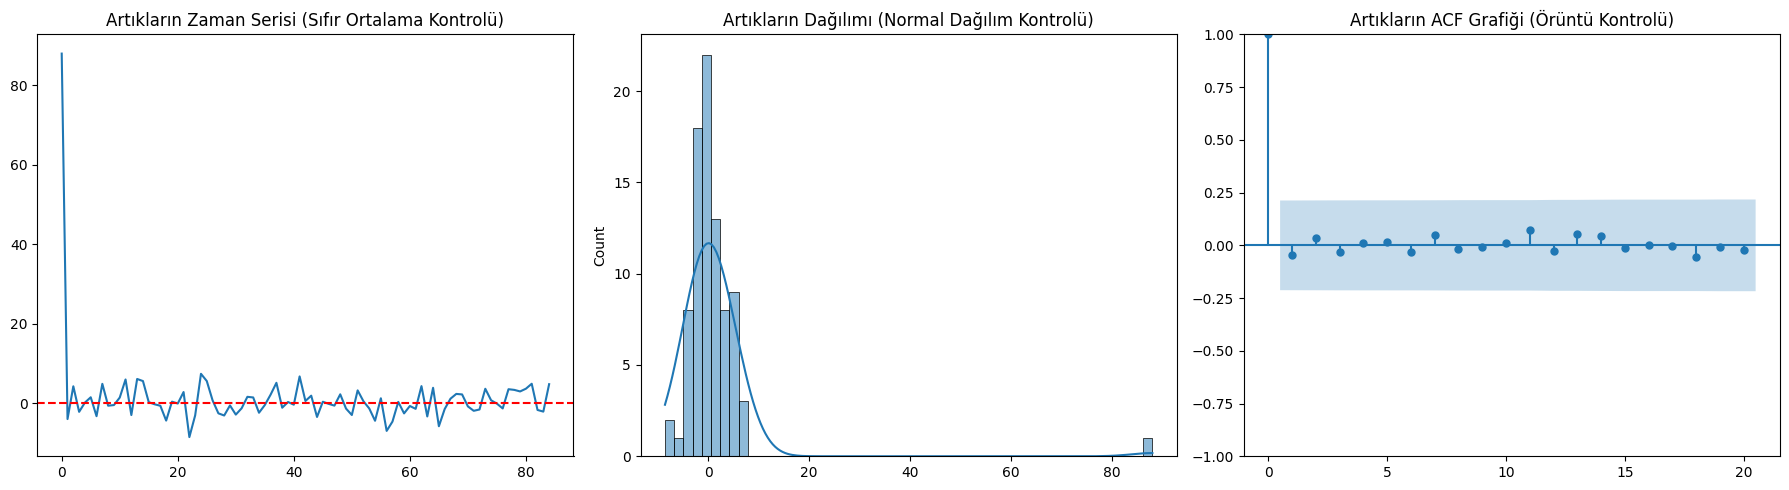

In [31]:
import seaborn as sns



residuals = arima_train_fit.resid

fig, ax = plt.subplots(1, 3, figsize=(18, 5))


ax[0].plot(residuals)
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_title('Artıkların Zaman Serisi (Sıfır Ortalama Kontrolü)')


import seaborn as sns
sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title('Artıkların Dağılımı (Normal Dağılım Kontrolü)')

plot_acf(residuals, ax=ax[2])
ax[2].set_title('Artıkların ACF Grafiği (Örüntü Kontrolü)')

plt.tight_layout()
plt.show()

## 3.3 Çapraz doğrulanmış performans ölçümleri

👉 Aşağıda zaman serileri için en yaygın performans ölçümleri yer almaktadır

In [32]:
import numpy as np
from statsmodels.tsa.stattools import acf

def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

👉 ARIMA hiper-parametrelerinizle oynayın ve tahmin performansınız üzerindeki etkisini görün

In [33]:
accuracy_metrics = forecast_accuracy(forecast_values, test)


for metric, value in accuracy_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")


MAPE: 0.1166
ME: -25.0429
MAE: 25.0429
MPE: -0.1166
RMSE: 30.2645
ACF1: 0.8724
CORR: 0.9008
MINMAX: 0.1166


## 4 Izgara Arama

`pmdarima` kullanarak (p,d,q) için bir Izgara Arama çalıştırmayı deneyin. En azından şunları kullanın:
- `test='adf'`
- `trace=True`
- `error_action='ignore'`
- `suppress_warnings=True`

In [36]:
import pmdarima as pm

model = pm.auto_arima(
    y_train,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,           # let model determine 'd'
    test='adf',       # using adf test to find optimal 'd'
    trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=73.896, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=75.084, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=70.955, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=72.741, Time=0.01 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.130 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 2, 1)   Log Likelihood                 -33.478
Date:                Thu, 22 Jan 2026   AIC                             70.955
Time:                        21:01:41   BIC                             72.085
Sample:                             0   HQIC  

/home/doganalper/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/doganalper/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/doganalper/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/doganalper/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/doganalper/.pyenv/versions/3.12.9/

## (İsteğe bağlı) Modelinizin Performansını Çapraz Doğrulayın

Pratikte, sonuçlar ve Izgara Arama her zaman çapraz doğrulanmalıdır:

Modelinizin performansını gerçekten değerlendirmek ve çapraz doğrulamadan sonra en iyi hiperparametreleri bulmak için bitişik K-katlar oluşturmak amacıyla [`sklearn.model_selection.TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) kullanmaktan çekinmeyin.

<img src='https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_013.png'>

**ARIMA - TimeSeriesSplit + Izgara Arama kullanarak Çapraz Doğrulama**

In [38]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

mape_scores = []

for train_index, test_index in tscv.split(y):
    
    cv_train, cv_test = y.iloc[train_index], y.iloc[test_index]
    
    
    cv_model = ARIMA(cv_train, order=(1, 1, 2)).fit()
    
    
    cv_forecast = cv_model.forecast(steps=len(cv_test))
    
    
    accuracy = forecast_accuracy(cv_forecast, cv_test)
    mape_scores.append(accuracy['mape'])

np.mean(mape_scores)

0.23673001478653566

In [39]:
df.sort_values('AIC').groupby('(p, d, q)').mean()['AIC'].sort_values()

KeyError: 'AIC'

☝️ İlk model seçimimiz (1, 1, 2) çok da kötü değil!
Veri seti (100 veri noktası) gerçekte herhangi bir şeyi çapraz doğrulamak için çok küçük olduğuna dikkat edin!